In [53]:
from dataloader import *
import numpy as np

import torch 
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import matplotlib.pyplot as plt
import time
import copy

import tqdm
import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [54]:
batch_size = 8
image_size = 512

# train transformations
train_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomRotation((-360, 360)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.ToTensor()
                                 ])

# validation transformations
test_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                 ])

train = RetinopathyLoader("./data/", "train", transform=train_trans, preprocessing=True)
test = RetinopathyLoader("./data/", "test", transform=test_trans, preprocessing=True)
# train = RetinopathyLoader("./data/", "train", transform=test_trans, preprocessing=False)
# test = RetinopathyLoader("./data/", "test", transform=test_trans, preprocessing=False)


# Create training and validation dataloaders
train_loader = DataLoader(
    dataset=train, 
    batch_size=batch_size,
    num_workers = 4
)

# [C, H, W] == [3, 512, 512]
test_loader = DataLoader(
    dataset=test,
    batch_size=batch_size,
    num_workers = 4
)

> Found 28099 images...
> Found 7025 images...


In [55]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avg_loss, avg_acc = 0, 0
    batch = 0
    for x, y in tqdm.notebook.tqdm(dataloader):
        x = x.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
        avg_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        batch+=1
    avg_loss /= len(dataloader)
    avg_acc /= len(dataloader.dataset)
    return 100*avg_acc, avg_loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in tqdm.notebook.tqdm(dataloader):
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return 100*correct, test_loss

In [56]:
num_classes = 5

## Pre-trained model

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# model = models.resnet18(pretrained=True)
# model = models.resnet50(pretrained=False)
model = torch.load('model.pt', map_location=device)
set_parameter_requires_grad(model, feature_extract)
# num_features = model.fc.in_features # the input channel of fc layer
# model.fc = nn.Linear(num_features, num_classes)
# model = model.to(device)
# print(model)
summary(model, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13        [-1, 256, 128, 128]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [57]:
## to check which params are going to learn
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_update, lr=0.0001, momentum=0.9, weight_decay=0.015)
# optimizer = optim.Adam(params_to_update, lr=0.005)

# Setup the loss fxn
loss_fn = nn.CrossEntropyLoss()

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

In [58]:
def save_acc(tr_acc, te_acc, tr_loss, te_loss):
    try:
        acc = np.load("acc.npz")
        np_train_acc = acc['train_acc']
        np_test_acc = acc['test_acc']
        np_train_loss = acc['train_loss']
        np_test_loss = acc['test_loss']
        np_train_acc = np.append(np_train_acc, tr_acc)
        np_test_acc = np.append(np_test_acc, te_acc)
        np_train_loss = np.append(np_train_loss, tr_loss)
        np_test_loss = np.append(np_test_loss, te_loss)
        np.savez('acc.npz', train_acc=np_train_acc, test_acc=np_test_acc, train_loss=np_train_loss, test_loss=np_test_loss)
    except:
        tr_acc = np.array(tr_acc)
        te_acc = np.array(te_acc)
        tr_loss = np.array(tr_loss)
        te_loss = np.array(te_loss)
        np.savez('acc.npz', train_acc=tr_acc, test_acc=te_acc, train_loss=tr_loss, test_loss=te_loss)


In [59]:
epochs = 1
save = True

train_acc = []
train_loss = []
test_acc = []
test_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tr_acc, tr_loss = train_loop(train_loader, model, loss_fn, optimizer)
    te_acc, te_loss = test_loop(test_loader, model, loss_fn)
    
    if save:
        save_acc(tr_acc, te_acc, tr_loss, te_loss)
    else:
        train_acc.append(tr_acc)
        train_loss.append(tr_loss)
        test_acc.append(te_acc)
        test_loss.append(te_loss)

    
print("Done!")

if save:
    print("Saving model weight...")
    torch.save(model, "./model.pt")
    print("Save Done!")

Epoch 1
-------------------------------


--- Logging error ---
--- Logging error ---
--- Logging error ---
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/ubuntu/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/ubuntu/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
--- Logging error ---
OSError: [Errno 5] Input/output error
  File "/home/ubuntu/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
Traceback (most recent call last):
Call stack:
  File "/home/ubuntu/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/ubuntu/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
 

  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/lib/python3.7/asyncio/base_events.py", line 1782, in _run_once
    handle._run()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/ubuntu/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_inst

  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<ipython-input-59-9efacdfd158b>", line 10, in <module>
    tr_acc, tr_loss = train_loop(train_loader, model, loss_fn, optimizer)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<ipython-input-55-6f0fcae2241a>", li

  File "<ipython-input-59-9efacdfd158b>", line 10, in <module>
    tr_acc, tr_loss = train_loop(train_loader, model, loss_fn, optimizer)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "<ipython-input-55-6f0fcae2241a>", line 5, in train_loop
    for x, y in tqdm.notebook.tqdm(dataloader):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tqdm/notebook.py", line 217, in __iter__
    for obj in super(tqdm_notebook, self).__iter__(*args, **kwargs):
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/context.py", line 223, in _Popen
    return _default_context.get_context().Process._Popen(process_obj)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/tqdm/std.py", line 1107, in __

  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/PIL/BmpImagePlugin.py", line 27, in <module>
    from . import Image, ImageFile, ImagePalette
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/PIL/BmpImagePlugin.py", line 27, in <module>
    from . import Image, ImageFile, ImagePalette
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootstrap>", line 1035, in _handle_fromlist
  File "<frozen importlib._bootst

  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 123, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 123, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
Message: 'W

loss: 0.253172  [    0/28099]
loss: 0.222625  [ 8000/28099]
loss: 1.183129  [16000/28099]
loss: 1.063658  [24000/28099]




Test Error: 
 Accuracy: 82.6%, Avg loss: 0.547236 

Done!
Saving model weight...
Save Done!


[78.24911032 80.28469751 80.61209964 80.27046263 81.09608541 80.89679715
 81.13879004 81.12455516 81.43772242 81.32384342 82.06405694 81.96441281
 82.57651246]


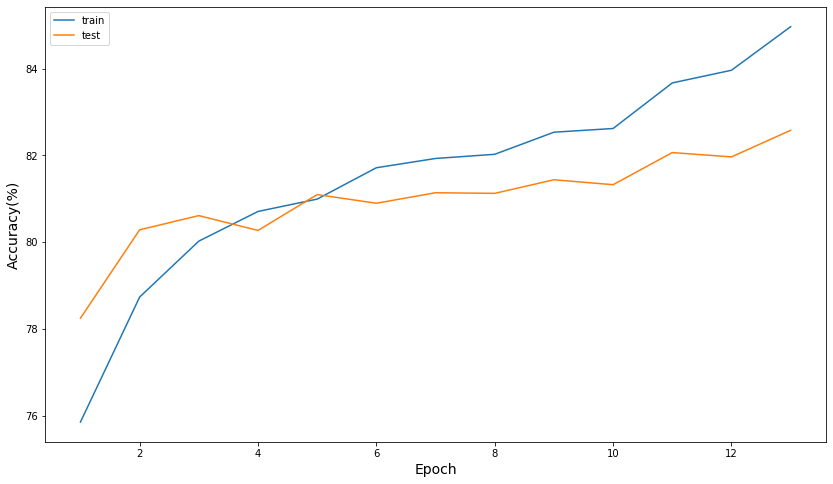

In [60]:
plt.figure(figsize=(14, 8))

load = True
if load:
    acc = np.load('acc.npz')
    train_acc = acc['train_acc']
    test_acc = acc['test_acc']

print(test_acc)
# plt.title("Activation Function comparision(EEGNet)", fontsize=18)
plt.ylabel("Accuracy(%)", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
x = np.arange(1, len(train_acc)+1)
plt.plot(x, train_acc, label="train")
plt.plot(x, test_acc, label="test")
plt.legend()
plt.show()

[0.65050281 0.60885439 0.59796454 0.60007112 0.5767213  0.58034122
 0.58193233 0.5842245  0.57909157 0.57787955 0.56190147 0.56268042
 0.5472356 ]


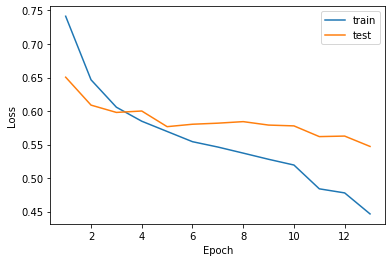

In [61]:
plt.figure()

load = True
if load:
    acc = np.load('acc.npz')
    train_loss = acc['train_loss']
    test_loss = acc['test_loss']

# plt.title("Activation Function comparision(EEGNet)")
plt.ylabel("Loss")
plt.xlabel("Epoch")
print(test_loss)
x = np.arange(1, len(train_loss)+1)
plt.plot(x, train_loss, label="train")
plt.plot(x, test_loss, label="test")
plt.legend()
plt.show()

In [62]:
model_load = torch.load('model.pt', map_location=device)
model_load.eval()

y_pred = []   
y_true = []   

test_loss, correct = 0, 0
with torch.no_grad():
    for x, y in tqdm.notebook.tqdm(test_loader):
        x = x.to(device)
        y = y.to(device)
        pred = model_load(x)
    #     test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        y_pred.extend(pred.argmax(1).detach().cpu().numpy())       # 將preds預測結果detach出來，並轉成numpy格式       
        y_true.extend(y.view(-1).detach().cpu().numpy())
    
correct /= len(test_loader.dataset)

print(f"Test Error: \n Accuracy: {(100*correct)}%")
# print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
# print(model_load)
# summary(model_load, (3, 512, 512))



Test Error: 
 Accuracy: 82.49110320284697%


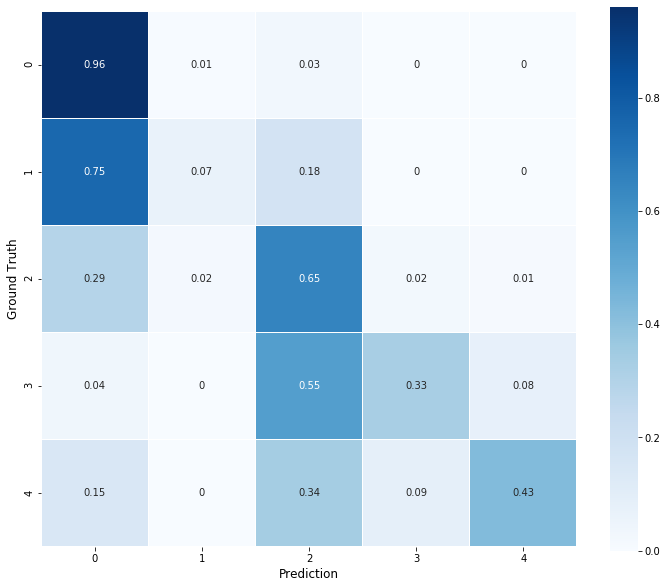

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
annot = np.around(cm, 2)

# plot matrix
fig, ax = plt.subplots(figsize = (12, 10))
sns.heatmap(cm, cmap = 'Blues', annot = annot, lw = 0.5)
ax.set_xlabel('Prediction', fontsize=12)
ax.set_ylabel('Ground Truth', fontsize=12)
ax.set_aspect('equal')